In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai.imports

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = '../../../data/dogscats/'
sz = 224

In [9]:
arch = resnet50
data = ImageClassifierData.from_paths(path=PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/paperspace/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 28630857.64it/s]


100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


In [70]:
lrf = learn.lr_find()

 67%|██████▋   | 241/360 [03:04<02:08,  1.08s/it, loss=0.247] 

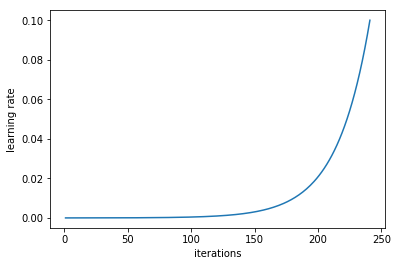

In [71]:
learn.sched.plot_lr()

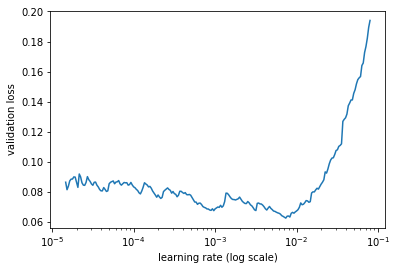

In [72]:
learn.sched.plot()

In [13]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.027332   0.029478   0.9915    
    1      0.028936   0.025512   0.9905                       



[array([0.02551]), 0.9905]

In [14]:
log_preds,y = learn.TTA()

In [23]:
probs = np.mean(np.exp(log_preds),0)

In [24]:
accuracy_np(probs, y)

0.9905

In [26]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[985  15]
 [  4 996]]


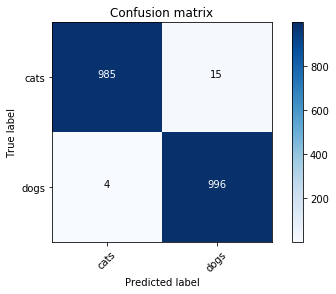

In [28]:
plot_confusion_matrix(cm, data.classes)

In [30]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y) == is_correct)

In [45]:
def most_by_mask(mask, mult):
    indices = np.where(mask)[0]
    return indices[np.argsort(mult * probs[indices])[:5]]


def most_by_correct(y, is_correct):
    if (y == 1) == is_correct:
        mult = -1
    else:
        mult = 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y == y), mult)

In [46]:
from PIL import Image

def plots(images, figsize=(12,6), rows=1, titles=None):
    fig = plt.figure(figsize=figsize)
    for idx in range(len(images)):
        subplot = fig.add_subplot(rows, len(images)//rows, idx+1)
        subplot.axis('off')
        if titles is not None:
            subplot.set_title(titles[idx], fontsize=16)
        plt.imshow(images[idx])

        
def load_image_id(dataset, idx):
    return np.array(Image.open(PATH+dataset.fnames[idx]))
        
    
def plot_val_with_title(indices, title):
    images = [load_image_id(data.val_ds, idx) for idx in indices]
    title_probs = [probs[idx] for idx in indices]
    print(title)
    if len(images) > 0:
        return plots(images, rows=1, titles=title_probs, figsize=(16,8))
    print('Not Found.')

Most incorrect cats


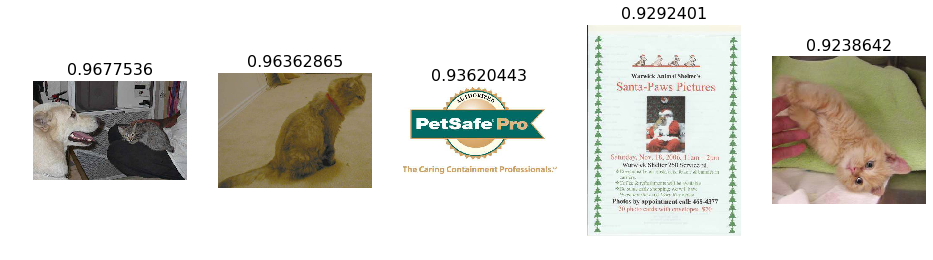

In [47]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [57]:
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [58]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [59]:
images = np.stack([get_augs() for i in range(6)])

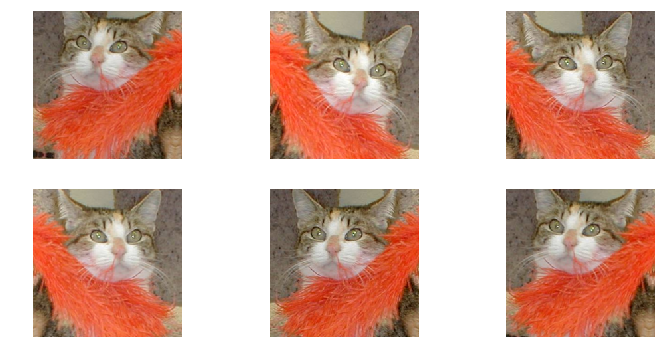

In [60]:
plots(images, rows=2)

In [94]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test1')
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [95]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04471    0.026488   0.99      
    1      0.043166   0.024901   0.9915                       
    2      0.03306    0.026141   0.991                        


[array([0.02614]), 0.991]

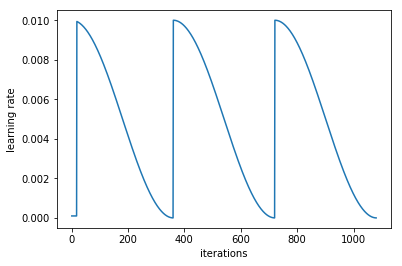

In [96]:
learn.sched.plot_lr()

In [97]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

In [100]:
learn.unfreeze()

In [101]:
learning_rates = np.array([1e-4, 1e-3, 1e-2])

In [102]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.042241   0.029376   0.9895    
    1      0.035709   0.026051   0.9905                       
    2      0.028831   0.02291    0.9915                       
    3      0.019248   0.020983   0.9935                       
    4      0.022642   0.022096   0.993                        
    5      0.013129   0.020471   0.993                        
    6      0.014301   0.021893   0.9925                       


[array([0.02189]), 0.9925]

In [103]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

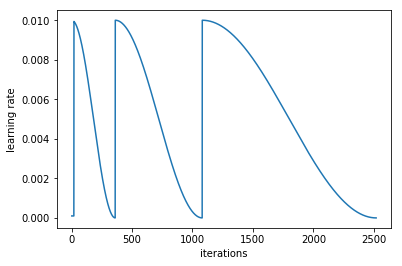

In [104]:
learn.sched.plot_lr()

In [ ]:
log_preds,y = learn.TTA(n_aug=4, is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [106]:
dog_probs = probs[:, 1]

In [113]:
probs[:3]

array([[0.00147, 0.99853],
       [0.9999 , 0.0001 ],
       [0.0012 , 0.9988 ]], dtype=float32)

In [107]:
test_ids = [fname.split('/')[1].replace('.jpg', '')
            for fname in test_data.test_ds.fnames]

In [108]:
submission = pd.DataFrame()
submission['id'] = test_ids
submission['label'] = dog_probs
submission = submission.sort_values('id')

In [109]:
submission.to_csv('../../../data/dogscats/kaggle_submission.csv',
                  index=None)

In [112]:
submission.head()

,id,label
7222,1,0.999962
4451,10,0.000264
7355,100,0.000069
11599,1000,0.999988
9370,10000,0.999943
